# Q3. Multilayer Perceptrons (30 marks)

<b>In this question, we will train and evaluate a single hidden layer MLP on the 
MNIST dataset.
You should use the pytorch library useful for answering the questions below.</b>


<b> (a) (5 marks)
Load the MNIST training and test set images and labels.
You can use the torchvision.datasets.MNIST class, or load them from the data
files at http://yann.lecun.com/exdb/mnist/ using your own code.
Convert each digit label to a one-hot representation, which is all zero except at
the position corresponding to the digit label (e.g., the one-hot
representation for 1 is the vector 
$(0, 1, 0, \ldots, 0) \in \mathbf{R}^{10}$).</b>

<b>How many examples are in the training and test sets?
What is the size of each digit image?</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torch import nn
from torchvision import transforms

## 下载数据集

In [2]:
trans = transforms.ToTensor()
# target_transform = ''
mnist_train = torchvision.datasets.MNIST(root="../data", train=True,
                                         transform=trans,
                                         download=True)
mnist_test = torchvision.datasets.MNIST(root="../data", train=False,
                                        transform=trans,
                                        download=True)

## 转换标签为 one-hot

In [3]:
class OneHot:
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, labels):
        labels = torch.tensor(labels)
        labels = nn.functional.one_hot(labels, num_classes=self.num_classes)
        return labels.float()

In [4]:
num_classes = 10
trans = transforms.ToTensor()
target_trans = OneHot(num_classes)
mnist_train = torchvision.datasets.MNIST(root="../data", train=True,
                                         transform=trans,
                                         target_transform=target_trans)
mnist_test = torchvision.datasets.MNIST(root="../data", train=False,
                                        transform=trans,
                                        target_transform=target_trans)

In [5]:
num_train = len(mnist_train)
num_test = len(mnist_test)
print(f"train num: {num_train}")
print(f"test num: {num_test}")

train num: 60000
test num: 10000


In [6]:
image, label = mnist_test[0]

In [7]:
image.shape # image shape

torch.Size([1, 28, 28])

In [8]:
label # one-hot

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

<b>(b) (10 marks)
Consider a single hidden layer MLP with 100 hidden units and 10 output
units, defined by  
$f(\mathbf{x}; W_{1}, W_{2}, b_{1}, b_{2}) = \sigma(W_{2} \sigma(W_{1} \mathbf{x} + b_{1}) + b_{2})$, where each 
$\mathbf{x} \in \mathbf{R}^{d}$ is the vector representation of a digit image, 
$W_{1} \in \mathbf{R}^{100 \times d}$ and 
$W_{2} \in \mathbf{R}^{10 \times 100}$ are the weight matrices, 
$b_{1} \in \mathbf{R}^{100}$ and $b_{2} \in \mathbf{R}^{10}$ are the biases, and 
$\sigma(u)$ applies the sigmoid function to each component of a vector $u$.</b>

<b>We want to train this MLP by minimizing the quadratic loss
\begin{align*}
  R_{n}(W_{1}, W_{2}, b_{1}, b_{2}) 
  = \frac{1}{n} \sum_{i=1}^{n} ||f(\mathbf{x}_{i}; W_{1}, W_{2}, b_{1}, b_{2}) - y_{i}||_{2}^{2},
\end{align*}
where 
$(\mathbf{x}_{1}, y_{1}), \ldots (\mathbf{x}_{n}, y_{n}) \in \mathbf{R}^{d} \times
\mathbf{R}^{10}$ is the training set.
    Note that you need to implement <font color=blue>exactly the same</font> loss as defined above</b>

<b>Starting with $W_{1}$, $W_{2}$, $b_{1}$, $b_{2}$ being 0, run gradient descent with step
size 0.01 for 100 iterations.</b>

<b>Compute the training and test set classification errors for the trained
model.
Here we use the trained model to make predictions by assigning an input
$\mathbf{x}$ to the index of the largest output.</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [9]:
from matplotlib import pyplot as plt
from IPython import display


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4.5, 3.5), window_title=None):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if window_title:
            self.fig.suptitle(window_title)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def try_gpu(i=0):  # @save
    """如果存在，则返回gpu(i)，否则返回cpu()。"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')


def train_epoch(net, train_iter, loss, updater, ctx):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(2)
    for X, y in train_iter:
        X = X.to(ctx)  # GPU
        y = y.to(ctx)
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch in-built optimizer & loss criterion
        updater.zero_grad()
        l.backward()
        updater.step()
        metric.add(float(l) * len(y), len(y))
    # Return training loss and training accuracy
    return metric[0] / metric[1]


def evaluate_loss(net, data_iter, ctx):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        X = X.to(ctx)  # GPU
        y = y.to(ctx)
        if len(y.shape) <= 1:
            y = y.expand([1, -1])
        y_hat = net(X)
        l = loss(y_hat, y)
        metric.add(float(l) * len(y), len(y))
    return metric[0] / metric[1]


def train_op(net, train_iter, test_iter, loss, num_epochs, updater, ctx, window_title=None):
    """Train a model"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=None,
                        legend=['train loss', 'train acc', 'test acc'], window_title=window_title)
    for epoch in range(num_epochs):
        train_losses = train_epoch(net, train_iter, loss, updater, ctx=ctx)
        test_losses = evaluate_loss(net, test_iter, ctx=ctx)
        animator.add(epoch + 1, (train_losses, test_losses))
    return animator

In [ ]:
# num_inputs, num_hiddens, num_outputs = 784, 100, 10

# W1 = nn.Parameter(
#     torch.zeros(num_inputs, num_hiddens, requires_grad=True) * 0.01)
# b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
# W2 = nn.Parameter(
#     torch.zeros(num_hiddens, num_outputs, requires_grad=True) * 0.01)
# b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

# params = [W1, b1, W2, b2]

# def net(X):
#     X = X.reshape((-1, num_inputs))
#     H = nn.Sigmoid()(X @ W1 + b1)
#     return nn.Sigmoid()(H @ W2 + b2)

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 100), nn.Sigmoid(),
                    nn.Linear(100, 10), nn.Sigmoid())


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.zeros_(m.weight)
        nn.init.zeros_(m.bias)


net.apply(init_weights)

ctx = try_gpu()
net = net.to(ctx)

loss = nn.MSELoss()  # L2 loss

num_epochs, lr = 100, 0.01
updater = torch.optim.SGD(net.parameters(), lr=lr)
train_iter = data.DataLoader(mnist_train, len(mnist_train), shuffle=True)
test_iter = data.DataLoader(mnist_test, len(mnist_test), shuffle=False)
train_op(net, train_iter, test_iter, loss,
         num_epochs, updater, ctx)

<b>(c) (5 marks)
Repeat (b) by training the MLP starting from parameters randomly chosen from $[-0.5, 0.5]$.
What are the training set and test set classification errors?</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 100), nn.Sigmoid(),
                    nn.Linear(100, 10), nn.Sigmoid())

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, -0.5, 0.5)
        nn.init.zeros_(m.bias)

net.apply(init_weights);

ctx = try_gpu()
net = net.to(ctx)

loss = nn.MSELoss() # L2 loss

num_epochs, lr = 100, 0.01
updater = torch.optim.SGD(net.parameters(), lr=lr)
train_iter = data.DataLoader(mnist_train, len(mnist_train), shuffle=True)
test_iter = data.DataLoader(mnist_test, len(mnist_test), shuffle=False)
train_op(net, train_iter, test_iter, loss, num_epochs, updater, ctx=try_gpu(0))

<b> (d) (5 marks)
Repeat (b) and (c) with each full gradient replaced by a stochastic gradient computed
over mini-batches of 100 examples, and running SGD for 100 epochs
(one epoch means one pass through the training data; thus 100 epochs is
equivalent to 100n/100=n SGD iterations).</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 100), nn.Sigmoid(),
                    nn.Linear(100, 10), nn.Sigmoid())

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, -0.5, 0.5)
        nn.init.zeros_(m.bias)

net.apply(init_weights);

ctx = try_gpu()
net = net.to(ctx)

loss = nn.MSELoss() # L2 loss

num_epochs, lr = 100, 0.01
updater = torch.optim.SGD(net.parameters(), lr=lr)

batch_size = 100
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False)

train_op(net, train_iter, test_iter, loss, num_epochs, updater, ctx=try_gpu(0))

<b> (e) (5 marks)
Train the MLP using the following learning rates 0.001, 0.1, and 1 for both
gradient descent and SGD, starting from 0 and random parameters.
Report the training set and test set classification errors for these 12
models.</b>

<b>Comment the performance of all the 16 models that you obtained above.
Which one has the best performance?
Can you explain why?</b>

**Answer**. [Write your solution here. Add cells as needed.]

In [10]:
def init_zero(m):
    if type(m) == nn.Linear:
        nn.init.zeros_(m.weight)
        nn.init.zeros_(m.bias)
        
def init_uniform(m):
    if type(m) == nn.Linear:
        nn.init.uniform_(m.weight, -0.5, 0.5)
        nn.init.zeros_(m.bias)
        
def data_iter(train_data, test_data, mode='all', batch_size=None):
    if mode == 'all':
        train_iter = data.DataLoader(train_data, len(train_data), shuffle=True)
        test_iter = data.DataLoader(test_data, len(test_data), shuffle=False)
    else:
        train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
        test_iter = data.DataLoader(test_data, batch_size, shuffle=False)
    return train_iter, test_iter
        
lr_lists = [0.01, 0.1, 1]

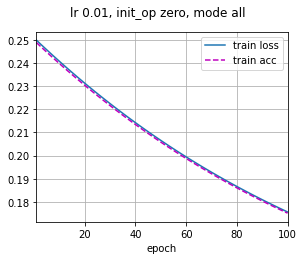

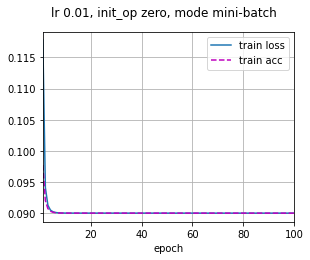

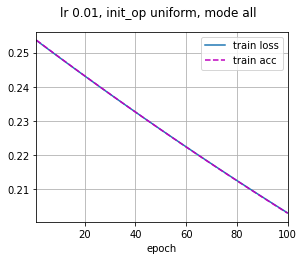

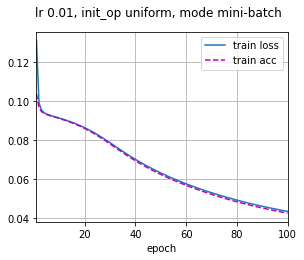

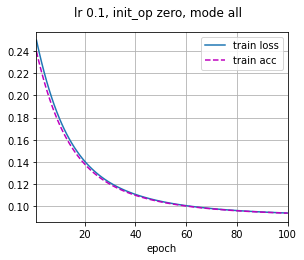

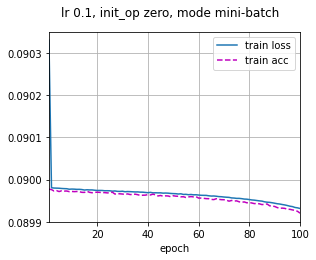

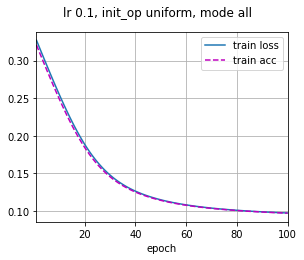

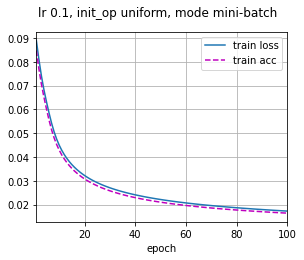

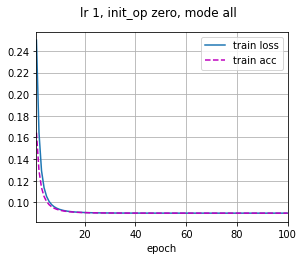

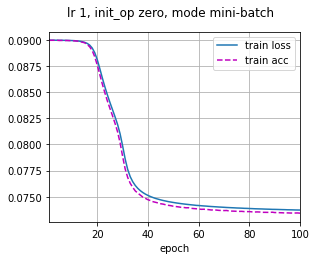

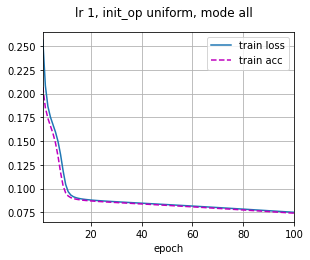

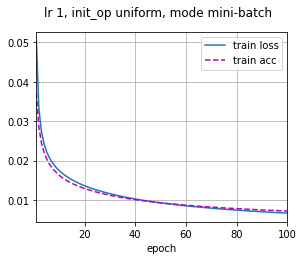

In [11]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 100), nn.Sigmoid(),
                    nn.Linear(100, 10), nn.Sigmoid())
ctx = try_gpu()
loss = nn.MSELoss() # L2 loss
num_epochs = 100
batch_size = 100

init_dict = {'zero': init_zero, 'uniform': init_uniform}

animators = {}
for lr in lr_lists:
    for init_name, init_op in init_dict.items():
        net.apply(init_op)
        net = net.to(ctx)
        updater = torch.optim.SGD(net.parameters(), lr=lr)
        for mode in ['all', 'mini-batch']:
            train_iter, test_iter = data_iter(mnist_train, mnist_test, mode, batch_size)
            window_title = f'lr {lr}, init_op {init_name}, mode {mode}'
            animator = train_op(net, train_iter, test_iter, loss, num_epochs, updater, ctx, window_title)
            animator.fig.savefig(window_title+'.jpg')
            animators[window_title] = animator

In [12]:
animators # 存储全部是损失

{'lr 0.01, init_op zero, mode all': <__main__.Animator at 0x19f844ef340>,
 'lr 0.01, init_op zero, mode mini-batch': <__main__.Animator at 0x19f844ef250>,
 'lr 0.01, init_op uniform, mode all': <__main__.Animator at 0x19fef725b80>,
 'lr 0.01, init_op uniform, mode mini-batch': <__main__.Animator at 0x19f8758b160>,
 'lr 0.1, init_op zero, mode all': <__main__.Animator at 0x19fef712670>,
 'lr 0.1, init_op zero, mode mini-batch': <__main__.Animator at 0x1a00f43bfd0>,
 'lr 0.1, init_op uniform, mode all': <__main__.Animator at 0x1a00f915e50>,
 'lr 0.1, init_op uniform, mode mini-batch': <__main__.Animator at 0x19ffbc006a0>,
 'lr 1, init_op zero, mode all': <__main__.Animator at 0x1a00f43b220>,
 'lr 1, init_op zero, mode mini-batch': <__main__.Animator at 0x19fbcec9b80>,
 'lr 1, init_op uniform, mode all': <__main__.Animator at 0x19fee154be0>,
 'lr 1, init_op uniform, mode mini-batch': <__main__.Animator at 0x19fef712cd0>}

In [15]:
for name, ani in animators.items():
    break

In [19]:
print(ani.Y)

[[0.25, 0.24896147847175598, 0.24792979657649994, 0.24690479040145874, 0.24588650465011597, 0.24487489461898804, 0.24387000501155853, 0.2428717464208603, 0.24188010394573212, 0.2408951073884964, 0.2399166375398636, 0.23894473910331726, 0.23797939717769623, 0.2370205521583557, 0.23606817424297333, 0.23512229323387146, 0.23418280482292175, 0.2332497388124466, 0.23232302069664001, 0.2314026802778244, 0.2304886430501938, 0.22958090901374817, 0.22867943346500397, 0.2277841866016388, 0.22689515352249146, 0.22601228952407837, 0.22513557970523834, 0.2242649793624878, 0.22340047359466553, 0.22254197299480438, 0.22168955206871033, 0.2208431214094162, 0.2200026512145996, 0.2191680669784546, 0.21833942830562592, 0.21751664578914642, 0.2166997194290161, 0.21588855981826782, 0.21508319675922394, 0.21428357064723969, 0.21348963677883148, 0.21270138025283813, 0.21191877126693726, 0.21114179491996765, 0.21037034690380096, 0.20960450172424316, 0.20884409546852112, 0.20808923244476318, 0.2073397934436798

In [21]:
ani.Y[0]

[0.25,
 0.24896147847175598,
 0.24792979657649994,
 0.24690479040145874,
 0.24588650465011597,
 0.24487489461898804,
 0.24387000501155853,
 0.2428717464208603,
 0.24188010394573212,
 0.2408951073884964,
 0.2399166375398636,
 0.23894473910331726,
 0.23797939717769623,
 0.2370205521583557,
 0.23606817424297333,
 0.23512229323387146,
 0.23418280482292175,
 0.2332497388124466,
 0.23232302069664001,
 0.2314026802778244,
 0.2304886430501938,
 0.22958090901374817,
 0.22867943346500397,
 0.2277841866016388,
 0.22689515352249146,
 0.22601228952407837,
 0.22513557970523834,
 0.2242649793624878,
 0.22340047359466553,
 0.22254197299480438,
 0.22168955206871033,
 0.2208431214094162,
 0.2200026512145996,
 0.2191680669784546,
 0.21833942830562592,
 0.21751664578914642,
 0.2166997194290161,
 0.21588855981826782,
 0.21508319675922394,
 0.21428357064723969,
 0.21348963677883148,
 0.21270138025283813,
 0.21191877126693726,
 0.21114179491996765,
 0.21037034690380096,
 0.20960450172424316,
 0.2088440954685